# Recommendation System Project
##### [1. Word Cloud Generation with "지원동기"](#1.-Word-Cloud-Generation)
##### [2. KCluster with values from word cloud](#2.-KCluster)
##### [3. FFM Prediction](#3.-FFM)

## 1. Word Cloud Generation

page_1_to_10.csv's valid motivs: 93 out of 96
page_11_to_22.csv's valid motivs: 105 out of 109
page_23_to_100.csv's valid motivs: 757 out of 757
page_101_to_200.csv's valid motivs: 946 out of 946
page_201_to_300.csv's valid motivs: 963 out of 963
page_301_to_376.csv's valid motivs: 738 out of 738
total valid reasons: 3602


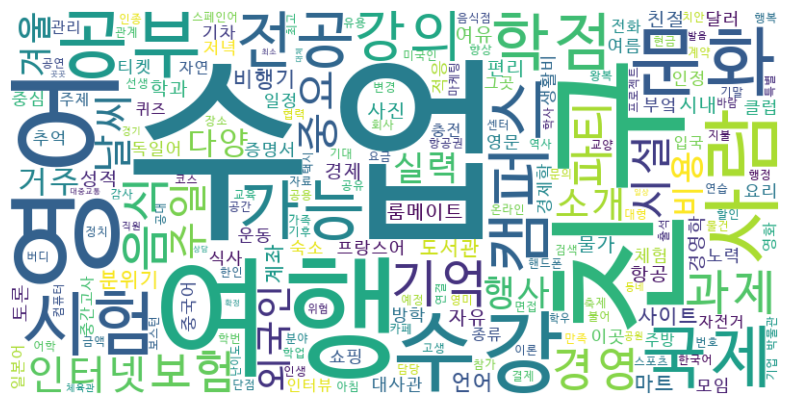

In [8]:
from extract_helper import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from konlpy.tag import Mecab
import os

path_to_files = "data_set"
files_to_process = ["page_1_to_10.csv", "page_11_to_22.csv", "page_23_to_100.csv", "page_101_to_200.csv", "page_201_to_300.csv", "page_301_to_376.csv"]

# 불용어 처리
stopwords = set()
with open("stopwords.txt", 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()  # 기본적으로 공백을 기준으로 split
        stopwords.update(words)  # set에 words 추가 (중복 제거)

# 각 파일에서 '지원 동기'에 해당하는 부분 parse
mecab = Mecab()  # mecab 형태소 분석기 생성
cleaned_text = ""
total_motivs = pd.Series(dtype=str)
for file_name in files_to_process:
    file_path = os.path.join(path_to_files, file_name)
    df = pd.read_csv(file_path)
    
    # csv 파일 내용 parse
    df['Selected Content'] = df.apply(select_content, axis=1)
    df['Processed Content'] = df.apply(process_content, axis=1)
    motivs = df['Processed Content'].dropna() # NAN 제거
    tot_len = len(motivs)
    motivs = motivs[motivs.str.strip() != ""]  # 빈 문자열 제거
    
    print(f"{file_name}'s valid motivs: {len(motivs)} out of {tot_len}")
    total_motivs = pd.concat([total_motivs, motivs])

    # 텍스트 전처리
    text = ' '.join(motivs)  # 모든 텍스트를 결합
    nouns = mecab.nouns(text)  # 명사만 추출
    nouns = [word for word in nouns if len(word) > 1] # 한글자 삭제

    # 명사 리스트를 하나의 문자열로 변환
    cleaned_text += ' '.join(nouns)

print(f"total valid reasons: {len(total_motivs)}")

# WordCloud 객체 생성
cleaned_text = cleaned_text.split()
cleaned_text_cnt = Counter(cleaned_text)
min_freq = 10
cleaned_text_flt = {word: count for word, count in cleaned_text_cnt.items() if count >= min_freq and word not in stopwords}

font_path = "/Users/gayeonlee/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttc"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, stopwords=stopwords).generate_from_frequencies(cleaned_text_flt)

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.rc('font', family='NanumGothicOTF')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()

